# **Notebook 02 – Análisis Exploratorio de Datos (EDA)**

Entender la estructura, calidad y comportamiento de los contratos del SECOP II, nos ayudara a comprender el analisis de estos:

  - Calcular estadisticas descriptivas
  - Valores nulos
  - Variable objetivo - (valor del contrato)
  - Analizar distribucion por departamento
  - Explorar tipo de contrato y estado
  - Outliers con metodo IQR
  - Dimensión temporal
  - Analisis temporal de contratos
    

In [1]:
# Importar librerías
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, sum as spark_sum, avg,
    min as spark_min, max as spark_max,
    stddev, isnan, when, isnull, desc,
    to_timestamp, to_date, year, month
)
# Para control de la ingesta
from pyspark.sql.functions import current_timestamp, input_file_name
from delta import *
import os
from sodapy import Socrata
import json
import pandas as pd

# Configurar SparkSession (cluster)
# %%
spark = SparkSession.builder \
    .appName("SECOP_EDA") \
    .master("spark://spark-master:7077") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")
print(f"Spark Master: {spark.sparkContext.master}")

# Cargar datos desde Parquet
# %%
parquet_path = "/opt/spark-data/raw/secop_base_ml.parquet"
print(f"Cargando datos desde: {parquet_path}")
df = spark.read.parquet(parquet_path)

print(f"Registros cargados: {df.count():,}")
print(f"Columnas: {len(df.columns)}")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/07 23:54:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Version: 3.5.0
Spark Master: spark://spark-master:7077
Cargando datos desde: /opt/spark-data/raw/secop_base_ml.parquet


Registros cargados: 100,000
Columnas: 8


26/02/07 23:54:48 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


### **Tiempo de analisis**

Lo ideal es saber en que tiempo estamos tratando la data dado que el SECOP II registra todos sus datos o solicitudes pero no las estan todas aprobadas por lo cual la informacion que se trajo fue de los ultimos 100 mil procesos que contemplan una fecha_de_firma la cual nos da a conocer cuales ya fueron tramitados.

In [2]:
print("\n=== VALIDACIÓN TEMPORAL: FECHA DE FIRMA ===")

# Verificar que la columna exista
if "fecha_de_firma" not in df.columns:
    raise ValueError("La columna 'fecha_de_firma' no existe en el DataFrame")

# Convertir a timestamp
df = df.withColumn(
    "fecha_de_firma_ts",
    to_timestamp(col("fecha_de_firma"))
)

# Validar fechas mínima y máxima
df.select(
    spark_min("fecha_de_firma_ts").alias("fecha_minima"),
    spark_max("fecha_de_firma_ts").alias("fecha_maxima")
).show(truncate=False)



=== VALIDACIÓN TEMPORAL: FECHA DE FIRMA ===
+-------------------+-------------------+
|fecha_minima       |fecha_maxima       |
+-------------------+-------------------+
|2025-10-29 00:00:00|2026-02-05 00:00:00|
+-------------------+-------------------+



### **Estadísticas descriptivas - Visión General del Dataset**

 1. Confirmar tamaño del dataset

In [3]:
print("=== DIMENSIONES DEL DATASET ===")
print(f"Registros: {df.count():,}")
print(f"Columnas: {len(df.columns)}")

=== DIMENSIONES DEL DATASET ===
Registros: 100,000
Columnas: 9


 2. Estadísticas descriptivas generales (Spark)

In [4]:
print("\n=== ESTADÍSTICAS DESCRIPTIVAS GENERALES ===")
df.describe().show(truncate=False)


=== ESTADÍSTICAS DESCRIPTIVAS GENERALES ===


26/02/08 00:09:34 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------------+-------------------+------------+--------------------------+-----------------------+---------------------+--------------------------------------------+---------------+
|summary|referencia_del_contrato|valor_del_contrato |departamento|tipo_de_contrato          |fecha_de_firma         |duraci_n_del_contrato|proveedor_adjudicado                        |estado_contrato|
+-------+-----------------------+-------------------+------------+--------------------------+-----------------------+---------------------+--------------------------------------------+---------------+
|count  |100000                 |100000             |100000      |100000                    |100000                 |100000               |100000                                      |100000         |
|mean   |1.6941895997855408E12  |2.4265245933637E8  |NULL        |NULL                      |NULL                   |NULL                 |7.030383121754386E8                         |NULL        

 3. Estadísticas específicas para la variable objetivo

In [5]:
df = df.withColumn(
    "valor_del_contrato_num",
    col("valor_del_contrato").cast("double")
)

print("\n=== ESTADÍSTICAS DEL VALOR DEL CONTRATO ===")
df.select(
    spark_min("valor_del_contrato_num").alias("min_valor"),
    spark_max("valor_del_contrato_num").alias("max_valor"),
    avg("valor_del_contrato_num").alias("promedio_valor"),
    stddev("valor_del_contrato_num").alias("desviacion_estandar")
).show(truncate=False)



=== ESTADÍSTICAS DEL VALOR DEL CONTRATO ===
+---------+----------+-----------------+-------------------+
|min_valor|max_valor |promedio_valor   |desviacion_estandar|
+---------+----------+-----------------+-------------------+
|0.0      |8.93052E11|2.4265245933637E8|4.663898767940789E9|
+---------+----------+-----------------+-------------------+



### **Análisis de valores nulos y estrategia**

Identificación de valores nulos

In [12]:
# Formato de las variables
from pyspark.sql.types import ( StringType, TimestampType, DateType,
    DoubleType, FloatType, IntegerType, LongType
)

cols_by_type = {
    "string": [],
    "numeric": [],
    "timestamp": [],
    "other": []
}

for f in df.schema.fields:
    if isinstance(f.dataType, (DoubleType, FloatType, IntegerType, LongType)):
        cols_by_type["numeric"].append(f.name)
    elif isinstance(f.dataType, (TimestampType, DateType)):
        cols_by_type["timestamp"].append(f.name)
    elif isinstance(f.dataType, StringType):
        cols_by_type["string"].append(f.name)
    else:
        cols_by_type["other"].append(f.name)

for k, v in cols_by_type.items():
    print(f"\n{k.upper()} ({len(v)} columnas)")
    for c in v:
        print(f" - {c}")


STRING (8 columnas)
 - referencia_del_contrato
 - valor_del_contrato
 - departamento
 - tipo_de_contrato
 - fecha_de_firma
 - duraci_n_del_contrato
 - proveedor_adjudicado
 - estado_contrato

NUMERIC (1 columnas)
 - valor_del_contrato_num

TIMESTAMP (1 columnas)
 - fecha_de_firma_ts

OTHER (0 columnas)


In [13]:
print("\n=== ANÁLISIS DE VALORES NULOS POR COLUMNA ===")

exprs = []

for c in df.columns:
    if c in numeric_cols:
        exprs.append(
            count(when(isnull(c) | isnan(c), c)).alias(c)
        )
    else:
        exprs.append(
            count(when(isnull(c), c)).alias(c)
        )

null_counts = df.select(exprs)

null_df = null_counts.toPandas().T
null_df.columns = ["null_count"]
null_df["null_percentage"] = (null_df["null_count"] / df.count()) * 100
null_df = null_df.sort_values("null_percentage", ascending=False)

null_df



=== ANÁLISIS DE VALORES NULOS POR COLUMNA ===


,null_count,null_percentage
referencia_del_contrato,0,0.0
valor_del_contrato,0,0.0
departamento,0,0.0
tipo_de_contrato,0,0.0
fecha_de_firma,0,0.0
duraci_n_del_contrato,0,0.0
proveedor_adjudicado,0,0.0
estado_contrato,0,0.0
fecha_de_firma_ts,0,0.0
valor_del_contrato_num,0,0.0


### **Explorar la variable objetivo (valor del contrato)**

In [18]:
from pyspark.sql.functions import (col, min as spark_min, max as spark_max,
    avg, stddev, count, when)

df.select(
    spark_min("valor_del_contrato_num").alias("min"),
    spark_max("valor_del_contrato_num").alias("max"),
    avg("valor_del_contrato_num").alias("promedio"),
    stddev("valor_del_contrato_num").alias("desviacion_std"),
    
    count(when(col("valor_del_contrato_num") < 10_000_000, True)).alias(" < 10M "),
    count(when((col("valor_del_contrato_num") >= 10_000_000) & (col("valor_del_contrato_num") < 100_000_000), True)).alias("  10M–100M  "),
    count(when((col("valor_del_contrato_num") >= 100_000_000) & (col("valor_del_contrato_num") < 1_000_000_000), True)).alias("  100M–1B  "),
    count(when(col("valor_del_contrato_num") >= 1_000_000_000, True)).alias(" > 1B ")
    ).show(truncate=False)


+---+----------+-----------------+-------------------+-------+------------+-----------+------+
|min|max       |promedio         |desviacion_std     | < 10M |  10M–100M  |  100M–1B  | > 1B |
+---+----------+-----------------+-------------------+-------+------------+-----------+------+
|0.0|8.93052E11|2.4265245933637E8|4.663898767940789E9|54361  |32644       |10102      |2893  |
+---+----------+-----------------+-------------------+-------+------------+-----------+------+



### **Analizar distribución por departamento**

In [19]:
from pyspark.sql.functions import sum as spark_sum, desc

df_dept = (
    df.groupBy("departamento")
      .agg(
          count("*").alias("num_contratos"),
          spark_sum("valor_del_contrato_num").alias("valor_total")
      )
      .orderBy(desc("num_contratos"))
      .limit(10)
)

df_dept.show(truncate=False)


+--------------------------+-------------+------------------+
|departamento              |num_contratos|valor_total       |
+--------------------------+-------------+------------------+
|Distrito Capital de Bogotá|22287        |1.0702179022143E13|
|Valle del Cauca           |13264        |1.136715069571E12 |
|Antioquia                 |8010         |3.227193849233E12 |
|Magdalena                 |5504         |1.074394983904E12 |
|Cundinamarca              |4982         |8.5968542829E11   |
|Santander                 |4295         |5.72199269132E11  |
|Atlántico                 |4026         |6.79591778195E11  |
|Bolívar                   |3754         |1.042373201211E12 |
|Tolima                    |3494         |2.67352774937E11  |
|Norte de Santander        |3225         |3.08096132719E11  |
+--------------------------+-------------+------------------+



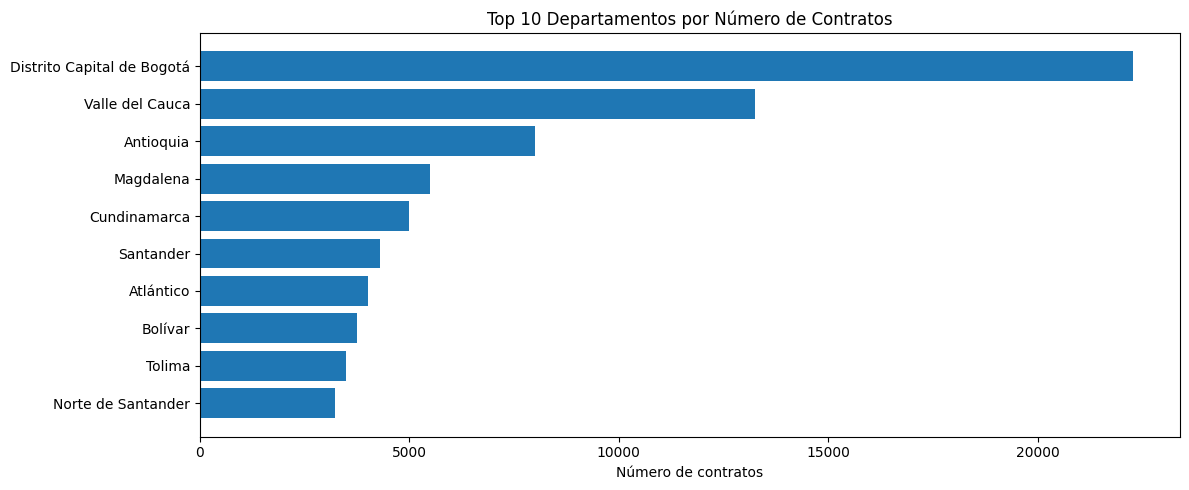

In [20]:
import matplotlib.pyplot as plt

pdf_dept = df_dept.toPandas()

plt.figure(figsize=(12,5))
plt.barh(pdf_dept["departamento"], pdf_dept["num_contratos"])
plt.title("Top 10 Departamentos por Número de Contratos")
plt.xlabel("Número de contratos")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### **Tipo de contrato**

In [21]:
df_tipo = (
    df.groupBy("tipo_de_contrato")
      .agg(count("*").alias("num_contratos"))
      .orderBy(desc("num_contratos"))
)

df_tipo.show(truncate=False)


+------------------------------+-------------+
|tipo_de_contrato              |num_contratos|
+------------------------------+-------------+
|Prestación de servicios       |71654        |
|Otro                          |7627         |
|Decreto 092 de 2017           |6766         |
|Compraventa                   |5301         |
|Suministros                   |3937         |
|Obra                          |2340         |
|Arrendamiento de inmuebles    |627          |
|Comodato                      |510          |
|Consultoría                   |446          |
|Interventoría                 |386          |
|Seguros                       |245          |
|Arrendamiento de muebles      |41           |
|Operaciones de Crédito Público|34           |
|Venta muebles                 |28           |
|Servicios financieros         |26           |
|No Definido                   |21           |
|Asociación Público Privada    |4            |
|Concesión                     |3            |
|Venta inmueb

### **Estado del contrato**

In [22]:
df_estado = (
    df.groupBy("estado_contrato")
      .agg(count("*").alias("num_contratos"))
      .orderBy(desc("num_contratos"))
)

df_estado.show(truncate=False)


+---------------+-------------+
|estado_contrato|num_contratos|
+---------------+-------------+
|En ejecución   |77170        |
|Modificado     |12605        |
|Aprobado       |6843         |
|terminado      |2080         |
|Suspendido     |944          |
|Cerrado        |299          |
|cedido         |59           |
+---------------+-------------+



### **Detectar outliers con metodo IQR**

In [27]:
# Cálculo de percentiles
df_valores_validos = df.filter(col("valor_del_contrato_num") > 0)
percentiles = df_valores_validos.approxQuantile(
    "valor_del_contrato_num",
    [0.25, 0.75],
    0.01
)

q1, q3 = percentiles
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Conteo de outliers
outliers = df_valores_validos.filter(
    (col("valor_del_contrato_num") < lower_bound) |
    (col("valor_del_contrato_num") > upper_bound)
)

num_outliers = outliers.count()
total_validos = df_valores_validos.count()

print(f"Outliers detectados: {num_outliers:,}")
print(f"Porcentaje: {(num_outliers / total_validos) * 100:.2f}%")




Outliers detectados: 15,101
Porcentaje: 15.30%


### **Analisis temporal de contratos**

In [24]:
df_time = (
    df.withColumn("fecha", to_date("fecha_de_firma"))
      .withColumn("anio", year("fecha"))
      .withColumn("mes", month("fecha"))
)

df_time.groupBy("anio", "mes") \
    .agg(count("*").alias("num_contratos")) \
    .orderBy("anio", "mes") \
    .show()

+----+---+-------------+
|anio|mes|num_contratos|
+----+---+-------------+
|2025| 10|         7289|
|2025| 11|        59341|
|2025| 12|        33268|
|2026|  1|           67|
|2026|  2|           35|
+----+---+-------------+



In [28]:
spark.stop()